In [2]:
!pip install torch==1.10.0+cpu torchvision==0.11.0+cpu torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html --user

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 199.3 MB 11 kB/s /s eta 0:00:01MB 109.5 MB/s eta 0:00:01
     |████████████████████████████████| 16.1 MB 80 kB/s  eta 0:00:01
     |████████████████████████████████| 2.7 MB 955 kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [112]:
!pip install skorch

     |████████████████████████████████| 155 kB 1.9 MB/s eta 0:00:01


In [200]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [74]:
data = pd.read_csv('/datasets/6_class.csv')
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


## Предобработка и анализ данных

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [76]:
data = data.drop('Unnamed: 0', axis=1)

На данном этапе уже можно разделить признаки на количественные и категориальнные. 

In [77]:
cat_features = ['Star type', 'Star color']
num_features = list(data.drop(cat_features, axis=1).columns)
num_features.remove('Temperature (K)') 
print(num_features)

['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']


<BarContainer object of 240 artists>

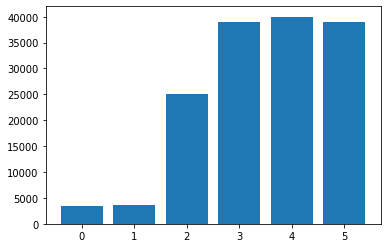

In [78]:
plt.bar(data['Star type'], data['Temperature (K)'])

<AxesSubplot:>

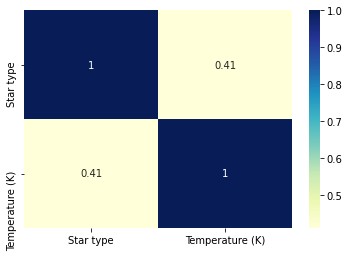

In [79]:
sb.heatmap(data[['Star type','Temperature (K)']].corr(), cmap="YlGnBu", annot=True)

Итак, по предыдущим двум графикам можно судить, что наибольшую температуру имеют Звёзды главной последовательности, Сверхгиганты и Гипергиганты. Так же можно заметить, что между температурой и типом звезды есть относительно средняя кореляция. 

In [80]:
data['Star color'] = data['Star color'].str.lower()
data['Star color'] = data['Star color'].str.strip()

In [81]:
print(data['Star color'].unique())

['red' 'blue white' 'white' 'yellowish white' 'pale yellow orange' 'blue'
 'blue-white' 'whitish' 'yellow-white' 'orange' 'white-yellow' 'yellowish'
 'orange-red']


<BarContainer object of 240 artists>

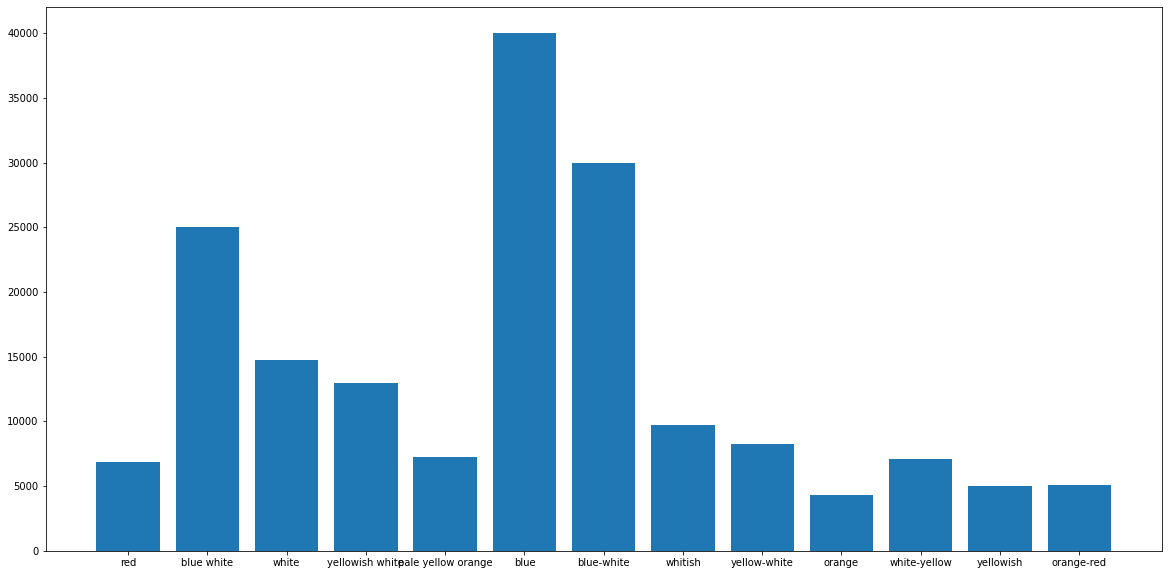

In [82]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.bar(data['Star color'], data['Temperature (K)'])

Итак, здесь мы можем наблюдать, что самые высокие температуры характерны для звезд голубого и бело-голубого цвета 

In [83]:
data[num_features].describe()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
count,240.000000,240.000000,240.000000
mean,107188.361635,237.157781,4.382396
std,179432.244940,517.155763,10.532512
min,0.000080,0.008400,-11.920000
25%,0.000865,0.102750,-6.232500
50%,0.070500,0.762500,8.313000
75%,198050.000000,42.750000,13.697500
max,849420.000000,1948.500000,20.060000


In [84]:
data.duplicated().sum()

0

In [85]:
data.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

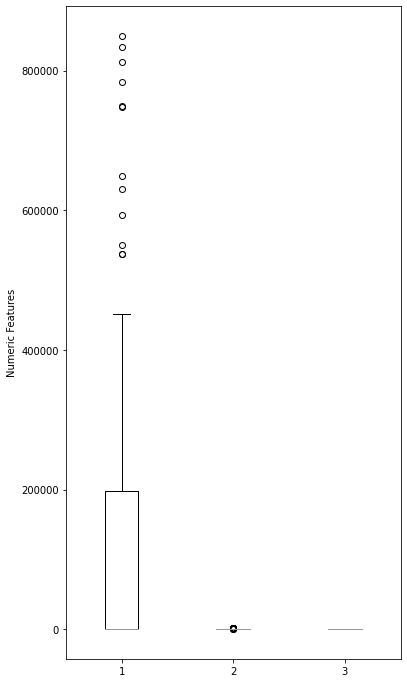

In [86]:
plt.subplots(figsize=(6, 12))
plt.boxplot(data[num_features], vert=True)
plt.ylabel("Numeric Features")
plt.show()

Здесь можно заметить, что во втором признаке очень много выбросов. Количественные данные необходимо стандартизировать

Преобразование категориальных и количественных признаков 

In [87]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,red
1,3042,0.000500,0.1542,16.60,0,red
2,2600,0.000300,0.1020,18.70,0,red
3,2800,0.000200,0.1600,16.65,0,red
4,1939,0.000138,0.1030,20.06,0,red


In [88]:
features = data.drop('Temperature (K)', axis=1)
target = data['Temperature (K)']

In [2]:
features_train, features_test, target_train, target_test = train_test_split(features,target, random_state=123)

In [90]:
print(features_train.shape)
print(features_test.shape)

(180, 5)
(60, 5)


In [91]:
print(target_train.shape)
print(target_test.shape)

(180,)
(60,)


In [92]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
enc.fit(features_train[cat_features])
features_train[cat_features] = enc.transform(features_train[cat_features])
features_test[cat_features] = enc.transform(features_test[cat_features])

/tmp/ipykernel_67/4047798367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[cat_features] = enc.transform(features_train[cat_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_67/4047798367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [93]:
scaler = StandardScaler()
scaler.fit(features_train[num_features])
features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

/tmp/ipykernel_67/2738894779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[num_features] = scaler.transform(features_train[num_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [94]:
features_train.head()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
205,-0.635640,-0.477004,0.716459,2.0,0.0
179,0.696747,1.655950,-1.133393,5.0,2.0
185,-0.635640,-0.476847,1.244584,0.0,6.0
192,-0.635640,-0.476504,0.915805,1.0,6.0
229,3.379859,-0.304061,-1.048931,4.0,0.0


In [95]:
features_test.head()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
128,-0.635640,-0.476883,1.493057,0.0,6.0
160,0.560071,-0.369864,-0.914207,4.0,0.0
62,-0.635640,-0.476854,1.165223,0.0,6.0
206,-0.635640,-0.477006,0.641823,2.0,0.0
79,-0.635640,-0.476728,0.965878,1.0,6.0


## Построение базовой нейронной сети

In [133]:
n_in_neurons = 5
n_hidden_neurons_1 = 4
n_hidden_neurons_2 = 3
n_out_neurons = 1 
n_hidden_neurons_3 = 3 
n_hidden_neurons_4 = 3

In [97]:
class NeuralNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.relu = nn.ReLU() 
        self.fc3 = nn.Linear(n_hidden_neurons_1, n_out_neurons)
        self.out = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.out(out)
        return out


    
net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

In [98]:
features_train = torch.FloatTensor(features_train.values)
features_test = torch.FloatTensor(features_test.values)
target_train = torch.FloatTensor(target_train.values)
target_test = torch.FloatTensor(target_test.values)

In [110]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

loss = nn.L1Loss()

num_epochs = 400
        
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(features_train).flatten()

    loss_value = loss(preds, target_train)

    loss_value.backward()

    optimizer.step()

    if epoch % 20 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(features_test)
        mse = mean_squared_error(target_test.detach().numpy(), test_preds.detach().numpy())
        print(mse)


134926000.0
134376140.0
133808670.0
133223500.0
132617010.0
131989690.0
131338480.0
130668410.0
129977530.0
129262184.0
128531120.0
127782120.0
127019530.0
126235550.0
125434120.0
124616630.0
123782320.0
122932024.0
122067304.0
121190920.0
120342320.0


In [103]:
plot_data = pd.DataFrame(target_test)
plot_data['Preds'] = test_preds.detach().numpy()
plot_data.columns = ['Target', 'Preds']
print(plot_data.head())

    Target       Preds
0   2856.0  626.080505
1  25390.0  382.384979
2   2983.0  622.369202
3  24020.0  274.261505
4   3158.0  697.259460


<AxesSubplot:>

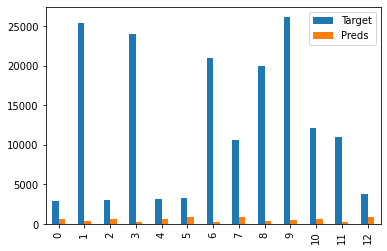

In [104]:
plot_data.loc[:12].plot(kind='bar')

Итак, пока можно сказать, что модель плохо справляется со своей задачей. Это можно увидеть и по метрике RMSE и по графику. Вся надежда на подбор параметров модели

## Улучшение нейронной сети

In [242]:
class Model(nn.Module):
    def __init__(self, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_hidden_neurons_4, dropout, activation):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(5, n_hidden_neurons_1)
        self.dp = nn.Dropout(p=dropout)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.layer4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.layer5 = nn.Linear(n_hidden_neurons_4, 1)
        self.activation = activation
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dp(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.dp(x)
        x = self.layer3(x)
        x = self.activation(x)
        x = self.dp(x)
        x = self.layer4(x)
        x = self.activation(x)
        x = self.dp(x)
        x = self.layer5(x)
        
        
        return x

In [243]:
n_in_neurons = 5
n_hidden_neurons_1 = 4
n_hidden_neurons_2 = 3
n_hidden_neurons_3 = 3
n_hidden_neurons_4 = 3
activation = nn.ReLU()
dropout = 0
n_out_neurons = 1

In [244]:
model_base = Model(n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_hidden_neurons_4, dropout, activation)

In [245]:
from sklearn.metrics import make_scorer
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

rmse_scorer = make_scorer(rmse) 

In [250]:
params = {
    'module__dropout': [0, 0.2, 0.5],
    'module__n_hidden_neurons_1': range(15, 30, 5),
    'module__n_hidden_neurons_2': range(10, 20, 4),
    'module__n_hidden_neurons_3': range(6, 13, 3),
    'module__n_hidden_neurons_4': range(3, 8, 2),
    'module__activation': [nn.LeakyReLU(), nn.Tanh(), nn.ReLU(), nn.ELU()],
    'lr': [1e-3, 1e-4]
}

In [251]:
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.regressor import NeuralNetClassifier
from skorch.dataset import ValidSplit
skorch_regressor = NeuralNetClassifier(module=model_base, 
                                      device='cpu',  
                                      verbose=3,
                                      batch_size=4,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=2500, 
                                      lr=1e-3,
                                      train_split=ValidSplit(cv=5),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=5)),
            ],
                                     ) 

In [252]:
grid = RandomizedSearchCV(skorch_regressor, params, cv=3, scoring="neg_root_mean_squared_error", verbose=3) 
grid.fit(features_train, target_train.reshape(-1, 1)) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
  epoch       RMSE      train_loss     valid_loss     dur
-------  ---------  --------------  -------------  ------
      1  7853.4660  246712232.9583  61676930.6667  0.0277
      2  7853.4505  246711820.3333  61676682.0000  0.0282
      3  7853.4334  246711367.6250  61676421.0000  0.0286
      4  7853.4151  246710879.5833  61676130.3333  0.0268
      5  7853.3954  246710357.6667  61675819.0000  0.0270
Stopping since RMSE has not improved in the last 5 epochs.
[CV 1/3] END lr=0.0001, module__activation=ELU(alpha=1.0), module__dropout=0, module__n_hidden_neurons_1=15, module__n_hidden_neurons_2=10, module__n_hidden_neurons_3=12, module__n_hidden_neurons_4=7; total time=   0.2s
  epoch        RMSE      train_loss      valid_loss     dur
-------  ----------  --------------  --------------  ------
      1  14942.3024  252359519.4167  223272416.0000  0.0272
      2  14942.2676  252358425.7917  223271377.6667  0.0252
      3  14942

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=Model(
    (layer1): Linear(in_features=5, out_features=4, bias=True)
    (dp): Dropout(p=0, inplace=False)
    (layer2): Linear(in_features=4, out_features=3, bias=True)
    (layer3): Linear(in_features=3, out_features=3, bias=True)
    (layer4): Linear(in_features=3, out_features=3, bi...
                   param_distributions={'lr': [0.001, 0.0001],
                                        'module__activation': [LeakyReLU(negative_slope=0.01),
                                                               Tanh(), ReLU(),
                                                               ELU(alpha=1.0)],
                                        'module__dropout': [0, 0.2, 0.5],
                                        'module__n_hidden_neurons_1': range(15, 30, 5),
                                        'module__n_hidden_neurons_2': range(10, 20, 4),
                

In [253]:
grid.best_params_

{'module__n_hidden_neurons_4': 5,
 'module__n_hidden_neurons_3': 9,
 'module__n_hidden_neurons_2': 18,
 'module__n_hidden_neurons_1': 25,
 'module__dropout': 0,
 'module__activation': ELU(alpha=1.0),
 'lr': 0.001}

In [255]:
final_net = Model(25, 18, 9, 5, 0, nn.ELU())

In [265]:
optimizer = torch.optim.Adam(final_net.parameters(), lr=0.001)

loss = nn.L1Loss()

num_epochs = 800
        
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = final_net.forward(features_train).flatten()

    loss_value = loss(preds, target_train)

    loss_value.backward()

    optimizer.step()

    if epoch % 40 == 0 or epoch == num_epochs - 1:
        final_net.eval()
        test_preds = final_net.forward(features_test)
        mse = mean_squared_error(target_test.detach().numpy(), test_preds.detach().numpy())
        rmse = mse ** 0.5
        print('RMSE -', rmse)
                

RMSE - 4743.006008851348
RMSE - 4736.595401762747
RMSE - 4719.22896244715
RMSE - 4704.570331071691
RMSE - 4664.737077263841
RMSE - 4641.404097899686
RMSE - 4612.649780765932
RMSE - 4603.297296503888
RMSE - 4581.833912310659
RMSE - 4560.1929783727355
RMSE - 4544.557184148968
RMSE - 4524.731373241952
RMSE - 4501.272931071831
RMSE - 4480.045758694882
RMSE - 4457.774332556551
RMSE - 4435.259631633756
RMSE - 4410.76750690852
RMSE - 4380.7771000131925
RMSE - 4352.307204230878
RMSE - 4319.540716326216
RMSE - 4296.156654499461


In [266]:
plot_data = pd.DataFrame(target_test)
plot_data['Preds'] = test_preds.detach().numpy()
plot_data.columns = ['Target', 'Preds']
print(plot_data.head())

    Target         Preds
0   2856.0   2828.000977
1  25390.0  18883.132812
2   2983.0   2985.605713
3  24020.0  20770.062500
4   3158.0   3124.079590


Text(0, 0.5, 'Температура звезды')

<Figure size 864x864 with 0 Axes>

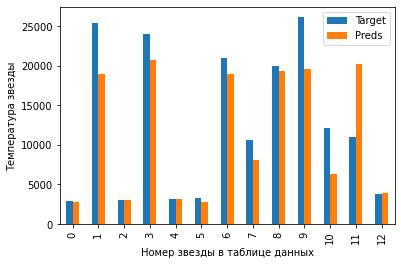

In [267]:
plt.figure(figsize=(12, 12))
fig = plot_data.loc[:12].plot(kind='bar')
fig.set_xlabel('Номер звезды в таблице данных')
fig.set_ylabel('Температура звезды')

## Выводы

Как можно заметить, новая и усложненная модель показывает более лучшие результаты. В нее был добавлен dropout, новый слой и функция активации. 